In [394]:
#from puppy.unfolder import PhononUnfolder
#from puppy.plotting import UnfolderPlotting
#from puppy.unfolder import * 
#import matplotlib.pyplot as plt

In [42]:
!export OMP_NUM_THREADS=1

In [1]:
directories = {'defect_directory':'/Users/badw/Documents/ntnu-projects/LiAlCl4/pbesol/V_Li/2x2x1/V_Li/0/phonons/',
                     'host_directory':'/Users/badw/Documents/ntnu-projects/LiAlCl4/pbesol/phonons/2x2x1/',
                    'defect_index':6}


directories = {'defect_directory':'/Users/badw/Documents/ntnu-projects/anti-perovskite/Li/Li3OCl/pbesol/phonons/3x3x3/v_li_init_phonons/',
               'host_directory':'/Users/badw/Documents/ntnu-projects/anti-perovskite/Li/Li3OCl/pbesol/phonons/3x3x3/kpoint_convergence/k1,1,1/',
               'defect_index':74}

### From Scratch 

In [114]:
# get primitive data and band structure 
import gzip,os
import tqdm_pathos 
from tqdm import tqdm
import itertools as it 
import copy 
from phonopy import load
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
from tqdm import tqdm
import numpy as np 
from phonopy import Phonopy
from phonopy.unfolding.core import Unfolding
from phonopy.phonon.band_structure import BandStructure, get_band_qpoints_by_seekpath
from pymatgen.io.phonopy import eigvec_to_eigdispl
from pymatgen.core import Structure

class Puppy:

    def __init__(self,
                 defect_directory,
                 host_directory,
                 line_density,
                 expansion,
                 defect_index,
                 nearest_neighbour_tolerance):
        self.defect_directory = defect_directory
        self.host_directory = host_directory
        self.line_density = line_density
        self.expansion = expansion
        self.defect_index = defect_index
        self.nearest_neighbour_tolerance = nearest_neighbour_tolerance

    def file_unzip(self, 
                   files):
        '''unzips a .gz file if present
            TODO: remove unzipped files afterwards'''
        for file in files:
            if os.path.exists(file):
                with gzip.open(file, 'rb') as f_in, open(file.replace('.gz', ''), 'wb') as f_out:
                    f_out.writelines(f_in)

    def get_neighbour_sites(self):
        self.file_unzip([self.host_directory+'SPOSCAR.gz'])

        struct = Structure.from_file(self.host_directory+'SPOSCAR')
        nearest_neighbours = struct.get_neighbor_list(self.nearest_neighbour_tolerance,
                                                      sites=[struct.sites[self.defect_index]])[1]
        unique_elements = list(dict.fromkeys([x.species_string for x in struct.sites]))
        neighbours = {}
        for elem in unique_elements:
            neighbours[elem] = [x for x in nearest_neighbours 
                                if struct.sites[x].species_string == elem]
        return(neighbours)
        

    def get_host_phonons(self):
        '''get the host or primitive phonons which the defect phonons will be unfolded back towards
        * currently assumes seekpath and has no manual kpoints mode, but this can be rectified in the future'''

        self.file_unzip([self.host_directory+'SPOSCAR.gz',
                         self.host_directory+'FORCE_SETS.gz'])
        
        ph = load(supercell_filename=self.host_directory+'SPOSCAR',
                  force_sets_filename=self.host_directory+'FORCE_SETS',
                  log_level=0)
        
        
        bands,labels,path_connections = get_band_qpoints_by_seekpath(primitive=ph.primitive,
                                                                     npoints=self.line_density,
                                                                     is_const_interval=False)
                
        ph.run_band_structure(bands,
                              with_eigenvectors=False,
                              path_connections=path_connections,
                              labels=labels) #old - needs to remove get_band_qpoints

        band_data = ph.get_band_structure_dict()
        self.host_band_data = band_data
        self.path_connections = path_connections
        self.labels=labels
        self.host = ph.primitive
        self.host_phonons = ph
    
    def eigenvectors_to_eigendisplacements(self):
        nn = self.get_neighbour_sites()
        atom_coords = self.defect_phonons.supercell.get_scaled_positions()
        num_atoms = self.defect_phonons.supercell.get_number_of_atoms()
        masses = self.defect_phonons.supercell.get_masses()
        #
        eigenvecs = self.defect_band_data['eigenvectors']
        qpts = self.host_band_data['qpoints']        
        
        eigendisplacements = {}
        for atom,sites in tqdm(nn.items(),desc='generating eigendisplacements...'):
            eigendisplacements[atom] = []
            for i,group in enumerate(eigenvecs):
                eigendisplacements[atom].append([])
                for ii,line in enumerate(group):
                    eigendisplacements[atom][i].append([])
                    for iii,freq in enumerate(line):
                        mean = [
                            [
                                np.linalg.norm(
                                    eigvec_to_eigdispl(
                                        freq[at],
                                        q=qpts[i][ii],
                                        frac_coords=atom_coords[at],
                                        mass=masses[at]
                                    )
                                )
                                for elem in sites if elem == at
                            ]
                            for at in range(num_atoms)
                        ]
                        eigendisplacements[atom][i][ii].append(np.mean(list(it.chain        (*mean))))
        self.eigendisplacements = eigendisplacements
        


    def get_defect_phonons(self):
        '''get the defect phonons which will be unfolded'''

        self.file_unzip([self.defect_directory+'SPOSCAR.gz',
                         self.defect_directory+'FORCE_SETS.gz'])
        
        bands,labels,path_connections = get_band_qpoints_by_seekpath(primitive=self.host,
                                                             npoints=self.line_density,
                                                             is_const_interval=False)
        
        ph = load(supercell_filename=self.defect_directory+'SPOSCAR',
                  force_sets_filename=self.defect_directory+'FORCE_SETS',
                  log_level=0)
                
        ph.run_band_structure(bands,
                              with_eigenvectors=True,
                              path_connections=path_connections,
                              labels=labels)
        

        band_data = ph.get_band_structure_dict()
        self.defect_band_data = band_data
        self.supercell = ph.supercell
        self.defect_phonons = ph
        self.special_points = [x[0] for x in ph.band_structure.qpoints]
        self.special_points.append(ph.band_structure.qpoints[-1][-1])

    def unfold(self):

        def mp_function(qpoints):
            mapping = [x for x in range(self.host_phonons.get_supercell().get_number_of_atoms())]
            mapping[self.defect_index] = None
            unfold = Unfolding(phonon = self.defect_phonons,
                   supercell_matrix = np.abs(np.linalg.inv(self.host_phonons.primitive_matrix).round(0)),
                   ideal_positions=self.host_phonons.get_supercell().get_scaled_positions(),
                   atom_mapping = mapping,
                   qpoints = qpoints
                   )
            unfold.run()
            weights = unfold.get_unfolding_weights()
            freqs = unfold.get_frequencies()
            return([freqs,weights])
        
        frequencies = []
        weights = []
        for q in tqdm(self.host_band_data['qpoints'],desc='unfolding phonons...'):
            freqs,wts = mp_function(q)
            frequencies.append(freqs)
            weights.append(wts)

        self.unfold_data = {'f':frequencies,'w':weights}

    def plot_unfold(self,base_colour=(0.1,0.1,0.1),with_prim=False,threshold=0.1):
                
        import matplotlib.pyplot as plt 
        import matplotlib.colors as mcolors
        from sumo.plotting import sumo_base_style
        plt.style.use(sumo_base_style)


        unfolded_weights = copy.deepcopy(self.unfold_data['w'])
        unfolded_freq = self.unfold_data['f']


        for i in range(len(unfolded_weights)):
            unfolded_weights[i][unfolded_weights[i]<threshold] = 0

        norm = mcolors.Normalize(vmin=np.min(unfolded_weights),vmax=np.max(unfolded_weights))

        line = self.host_band_data['distances']
        path_connections = self.path_connections
        labels =self.labels
        distances = self.host_band_data['distances']

        axiscount = 1
        for i,x in enumerate(path_connections[:-1]):
            if i > 0 :
                if not path_connections[i] == path_connections[i-1]:
                    axiscount+=1

        import collections

        sizing = collections.Counter(path_connections[:-1]).values()

        fig,axes = plt.subplots(ncols=axiscount,figsize=(6,6),dpi=300,sharey=True,gridspec_kw={'width_ratios':sizing})

        if with_prim == True:
            for dist,freq in zip(self.host_band_data['distances'],self.host_band_data['frequencies']):
                axes[0].plot(dist,freq,color='tab:blue',alpha=0.5)
                axes[1].plot(dist,freq,color='tab:blue',alpha=0.5)

        axisvlines = [0]

        totallen = len(distances)
        count = 0 
        fig.axes[count].axvline(axisvlines[0])

        for i,(l,connect,label) in enumerate(zip(distances,path_connections,labels)):
            
            if not l[0] in axisvlines:
                fig.axes[count].axvline(l[0],color='k')
                axisvlines.append(l[0])
            if not l[-1] in axisvlines:
                fig.axes[count].axvline(l[0],color='k')
                axisvlines.append(l[-1])

            qpts = [[q for x in range(len(unfolded_freq[i][0]))] for q in line[i]]
            cols = [[mcolors.to_rgba(base_colour,alpha=unfolded_weights[i][w1][w2])
                            for w2 in range(len(unfolded_weights[i][w1]))] 
                           for w1 in range(len(unfolded_weights[i]))]
                
            for ii,qq in enumerate(qpts):
                collection = fig.axes[count].scatter(x=qq,y=unfolded_freq[i][ii],c=cols[ii],edgecolor=None,linewidths=0,norm=norm,s=5)
            
            if not connect:
                if not i == totallen:
                    count+=1    


        lefts = [0]
        rights = []
        for i, c in enumerate(path_connections):
            if not c:
                lefts.append(i + 1)
                rights.append(i)
            seg_indices = [list(range(lft, rgt + 1)) for lft, rgt in zip(lefts, rights)]
            special_points = []
            for indices in seg_indices:
                pts = [distances[i][0] for i in indices]
                pts.append(distances[indices[-1]][-1])
                special_points.append(pts)        

        l_count = 0         

        for ax, spts in zip(axes,special_points):
            ax.set_xticks(spts)
            ax.set_xlim(spts[0],spts[-1])
            ax.set_xticklabels(labels[l_count : (l_count + len(spts))])
            l_count += len(spts)        
        
        

        axes[0].set_ylabel('Frequency (THz)')    

        return(plt)

In [115]:
import warnings 
warnings.simplefilter('ignore')
puppy = Puppy(defect_directory=directories['defect_directory'],
              host_directory=directories['host_directory'],
              line_density=10,
              expansion=[3,3,3],
              defect_index=74,
              nearest_neighbour_tolerance=3)
puppy.get_host_phonons()
puppy.get_defect_phonons()
#puppy.unfold()
puppy.eigenvectors_to_eigendisplacements()

generating eigendisplacements...:   0%|          | 0/3 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [85]:
puppy.get_neighbour_sites(tol=2.8)

{'Li': [11, 20, 38, 47, 9, 41, 18, 74, 50],
 'Cl': [101, 104, 99, 102],
 'O': [119, 128]}

In [90]:
eigendisplacements = [[[]]]


eigendisplacements[0][0].append(1)

eigendisplacements

[[[1]]]

In [108]:
atom_coords = puppy.defect_phonons.supercell.get_scaled_positions()
num_atoms = puppy.defect_phonons.supercell.get_number_of_atoms()
masses = puppy.defect_phonons.supercell.get_masses()
#
nn = puppy.get_neighbour_sites()
eigenvectors = puppy.defect_band_data['eigenvectors']
qpts = puppy.host_band_data['qpoints']


eigendisplacements = {}
for atom,sites in tqdm(nn.items(),desc='grabbing eigendisplacements...'):
    eigendisplacements[atom] = []
    for i,group in enumerate(eigenvectors):
        eigendisplacements[atom].append([])
        for ii,line in enumerate(group):
            eigendisplacements[atom][i].append([])
            for iii,freq in enumerate(line):
                mean = [
                    [
                        np.linalg.norm(
                            eigvec_to_eigdispl(
                                freq[at],
                                q=qpts[i][ii],
                                frac_coords=atom_coords[at],
                                mass=masses[at]
                            )
                        )
                        for elem in sites if elem == at
                    ]
                    for at in range(num_atoms)
                ]
                eigendisplacements[atom][i][ii].append(np.mean(list(it.chain(*mean))))


grabbing eigendisplacements...: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


In [101]:
eigendisplacements

[[[0.0014873529838853794,
   0.010828559420701715,
   0.009153585805432001,
   0.0032534273187628,
   0.021309129681007444,
   0.006224783929150213,
   0.001838291768211272,
   0.015691951678872006,
   0.008129161160532609,
   0.0015144788662563352,
   0.015756813423159717,
   0.004464674755129279,
   0.0012343594496548897,
   0.01868563191624835,
   0.005869549711116627,
   0.0014852634490335724,
   0.018776246513837316,
   0.006694879689150466,
   0.0017830660969179071,
   0.010786010166019051,
   0.00789515066092792,
   0.0024047245765079824,
   0.01613088194933453,
   0.007454096429721872,
   0.003563337535754629,
   0.02148915082930957,
   0.006561627334382526,
   0.0014500128495861459,
   0.015101658867640743,
   0.00682800107247597,
   0.0035690207617264766,
   0.0150701033376677,
   0.00796675701068088,
   0.0035568001869629162,
   0.01500120292832319,
   0.007196714560407701,
   0.0013726743511147535,
   0.011543555772118698,
   0.003973002087926354,
   0.0022452925145547108,


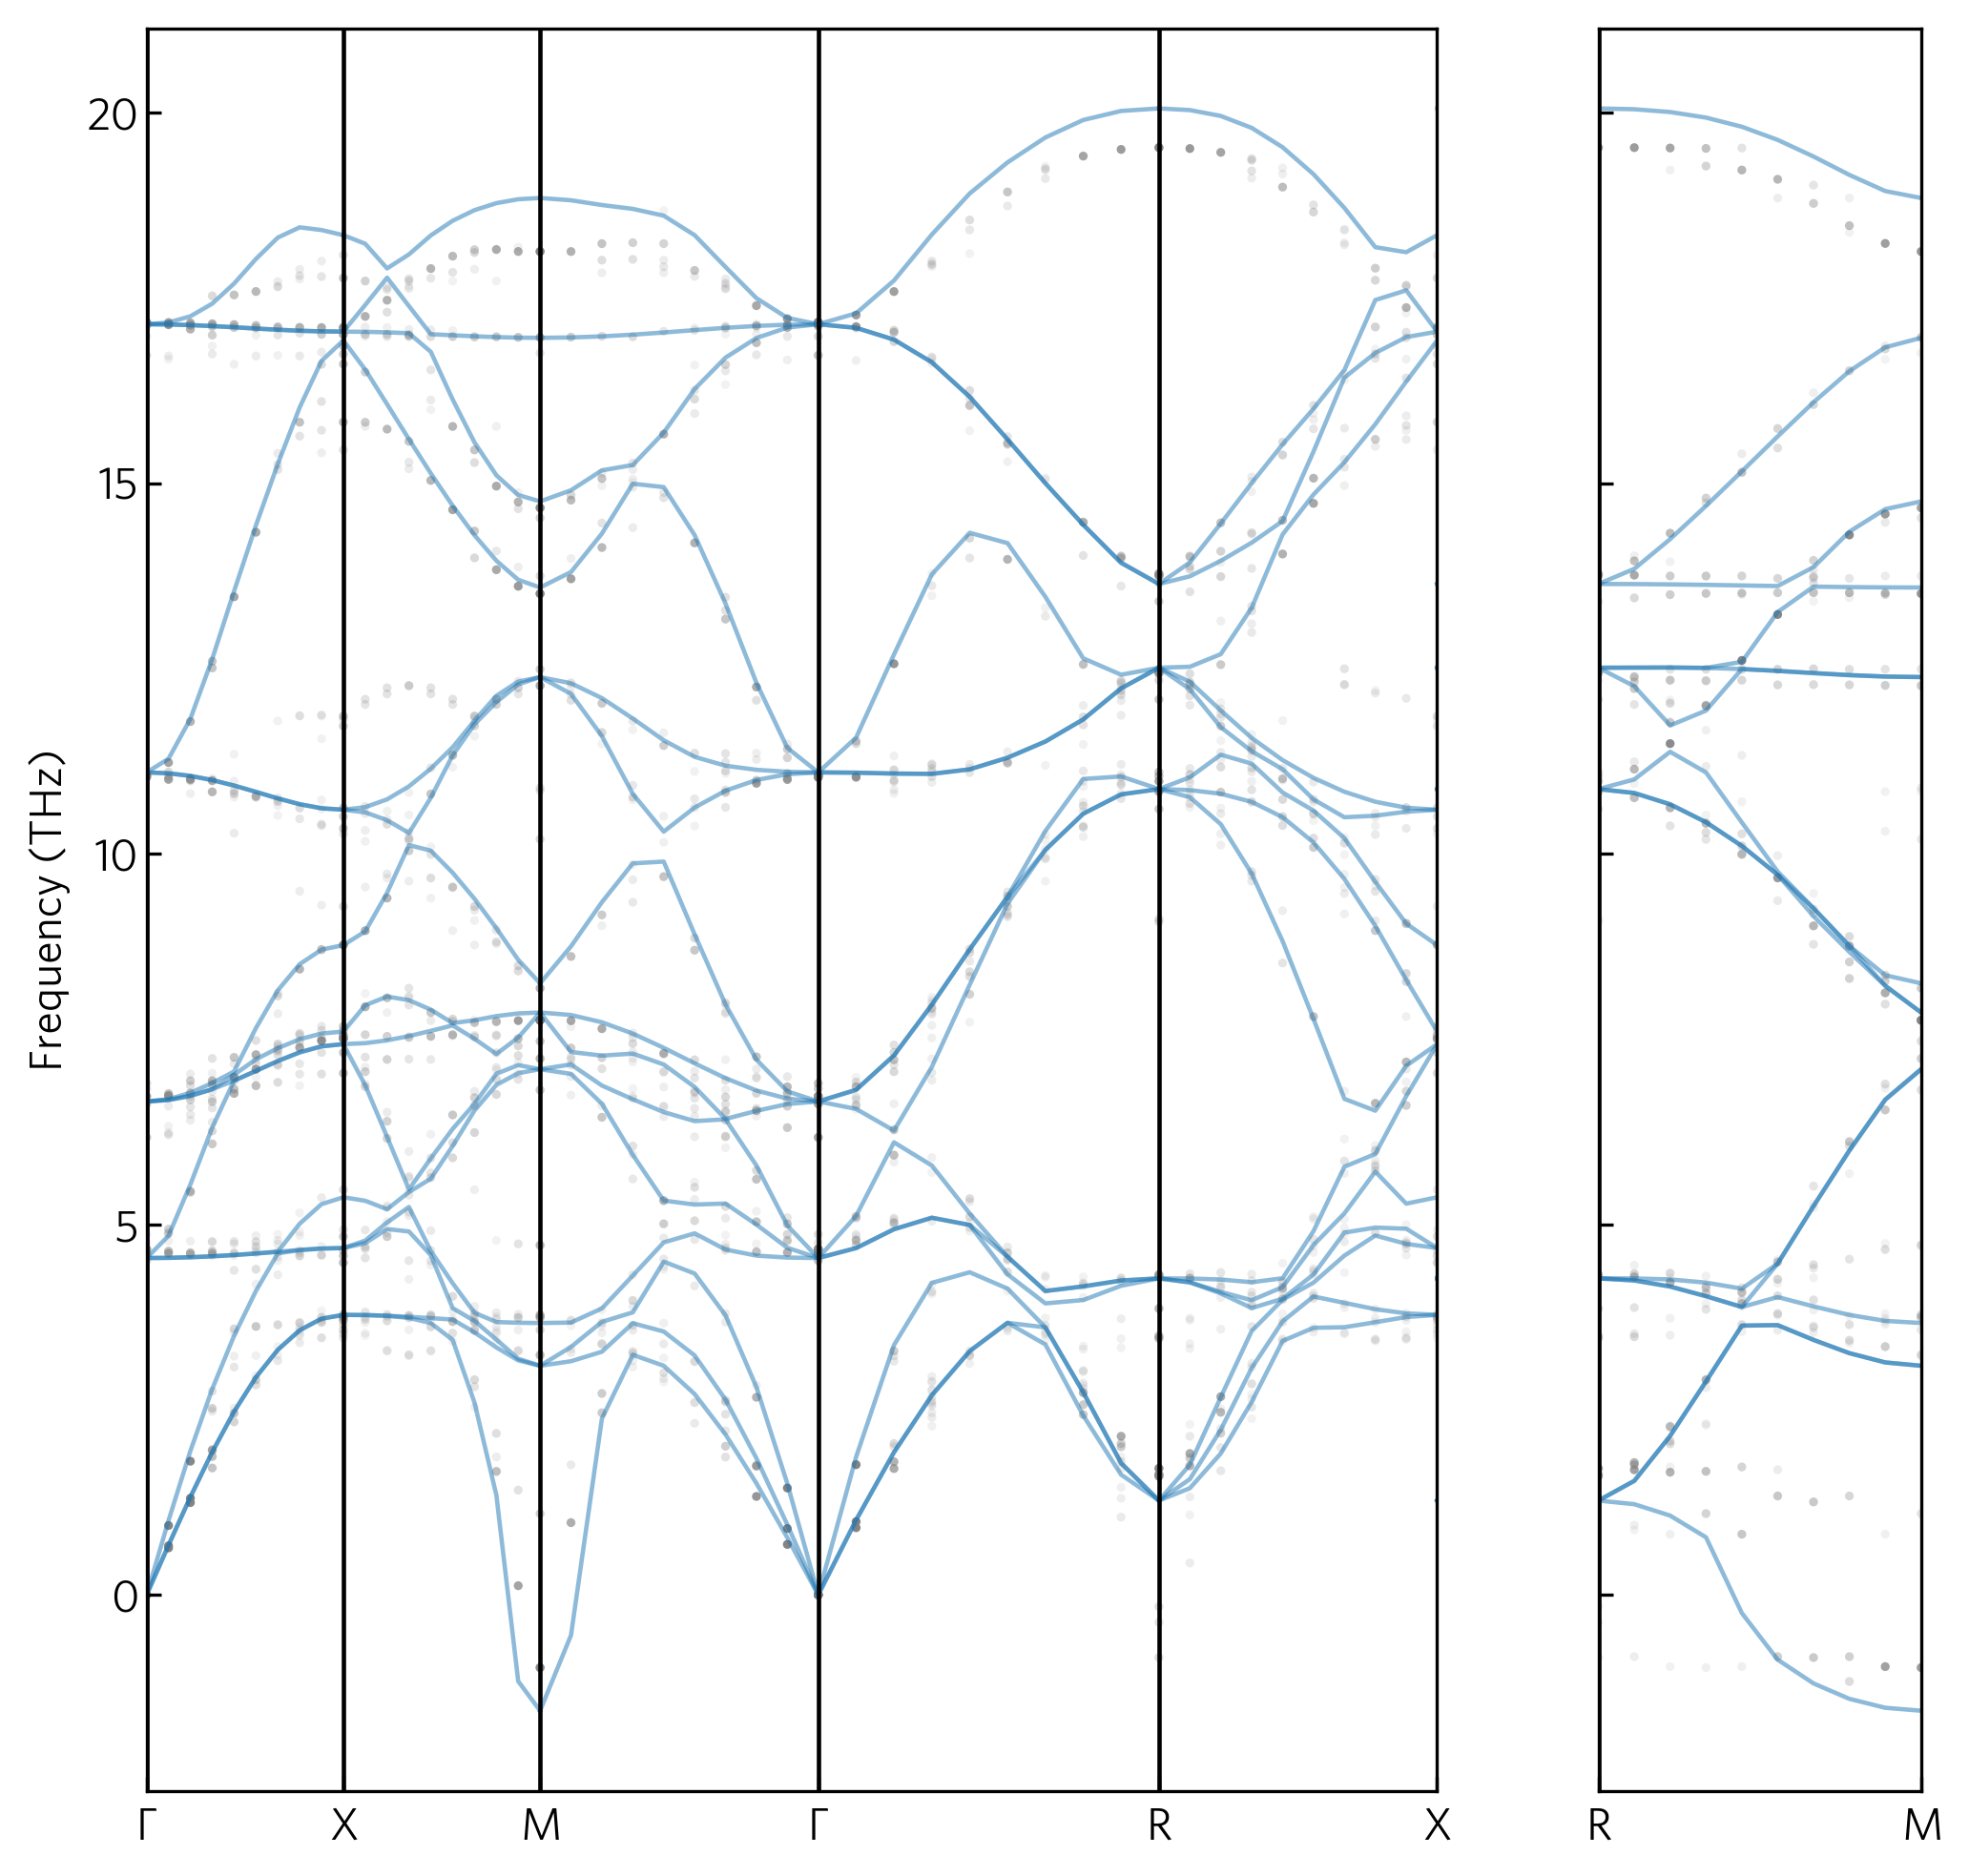

In [13]:
plt = puppy.plot_unfold(base_colour=(0.5,0.5,0.5),with_prim=True,threshold=0.1)

In [14]:
np.shape(puppy.defect_band_data['eigenvectors'])

(6, 10, 402, 402)

In [27]:
np.shape(puppy.unfold_data['f'])

(6, 10, 402)

In [31]:
eigenvec = puppy.defect_band_data['eigenvectors']
eigenvec[0][0][0]

array([-8.16945698e-14+0.j,  5.97458342e-02+0.j, -3.64330046e-19+0.j,
       -2.76771961e-05+0.j,  1.27716211e-04+0.j, -4.28355557e-05+0.j,
        2.49793064e-04+0.j, -2.24044655e-04+0.j,  2.61443258e-02+0.j,
       -3.49774923e-04+0.j, -9.51059456e-04+0.j,  4.98083081e-04+0.j,
        5.55613971e-02+0.j, -3.30238170e-02+0.j, -1.12308497e-02+0.j,
       -2.88885871e-03+0.j, -3.66486233e-03+0.j,  3.29440628e-02+0.j,
        5.08005052e-03+0.j,  1.09892103e-03+0.j, -2.32129850e-02+0.j,
       -6.12710836e-03+0.j, -4.16813155e-03+0.j, -2.90599597e-04+0.j,
        1.77288887e-03+0.j,  2.10685664e-03+0.j,  1.52656335e-02+0.j,
       -2.50510665e-02+0.j, -2.28348356e-03+0.j, -2.59980222e-03+0.j,
        8.73511267e-04+0.j,  3.07626979e-05+0.j,  5.84568495e-04+0.j,
        1.14954742e-03+0.j,  6.53950833e-03+0.j, -2.13416337e-03+0.j,
       -8.05749886e-04+0.j, -2.49659925e-04+0.j, -1.55724874e-03+0.j,
       -3.36833889e-02+0.j,  8.27772585e-03+0.j,  5.66413115e-05+0.j,
        1.19474855e-

<module 'matplotlib.pyplot' from '/Users/badw/miniconda3/envs/py311/lib/python3.11/site-packages/matplotlib/pyplot.py'>

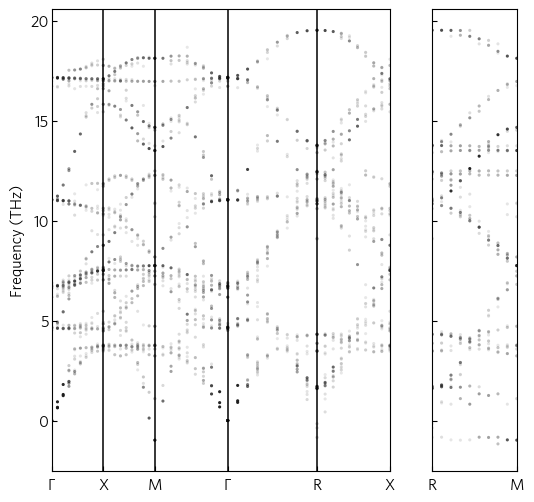

In [23]:
def plot_unfold(base_colour=(0.1, 0.1, 0.1), with_prim=False, threshold=0.1):

    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    from sumo.plotting import sumo_base_style
    plt.style.use(sumo_base_style)

    unfolded_weights = copy.deepcopy(puppy.unfold_data['w'])
    unfolded_freq = puppy.unfold_data['f']

    for i in range(len(unfolded_weights)):
         unfolded_weights[i][unfolded_weights[i] < threshold] = 0
    norm = mcolors.Normalize(vmin=np.min(
         unfolded_weights), vmax=np.max(unfolded_weights))
    line = puppy.host_band_data['distances']
    path_connections = puppy.path_connections
    labels = puppy.labels
    distances = puppy.host_band_data['distances']
    axiscount = 1
    for i, x in enumerate(path_connections[:-1]):
        if i > 0:
            if not path_connections[i] == path_connections[i-1]:
                axiscount += 1
    import collections
    sizing = collections.Counter(path_connections[:-1]).values()
    fig, axes = plt.subplots(ncols=axiscount, figsize=(
        6, 6), dpi=100, sharey=True, gridspec_kw={'width_ratios': sizing})
    if with_prim == True:
        for dist, freq in zip(puppy.host_band_data['distances'], puppy.host_band_data['frequencies']):
            axes[0].plot(dist, freq, color='tab:blue', alpha=0.5)
            axes[1].plot(dist, freq, color='tab:blue', alpha=0.5)
    axisvlines = [0]
    totallen = len(distances)
    count = 0
    fig.axes[count].axvline(axisvlines[0])
    for i, (l, connect, label) in enumerate(zip(distances, path_connections, labels)):
        if not l[0] in axisvlines:
            fig.axes[count].axvline(l[0], color='k')
            axisvlines.append(l[0])
        if not l[-1] in axisvlines:
            fig.axes[count].axvline(l[0], color='k')
            axisvlines.append(l[-1])
        qpts = [[q for x in range(len(unfolded_freq[i][0]))]
                for q in line[i]]
        cols = [[mcolors.to_rgba(base_colour, alpha=unfolded_weights[i][w1][w2])
                 for w2 in range(len(unfolded_weights[i][w1]))]
                for w1 in range(len(unfolded_weights[i]))]
        for ii, qq in enumerate(qpts):
            collection = fig.axes[count].scatter(
                x=qq, y=unfolded_freq[i][ii], c=cols[ii], edgecolor=None, linewidths=0, norm=norm, s=5)
        if not connect:
            if not i == totallen:
                count += 1
    lefts = [0]
    rights = []
    for i, c in enumerate(path_connections):
        if not c:
            lefts.append(i + 1)
            rights.append(i)
        seg_indices = [list(range(lft, rgt + 1))
                       for lft, rgt in zip(lefts, rights)]
        special_points = []
        for indices in seg_indices:
            pts = [distances[i][0] for i in indices]
            pts.append(distances[indices[-1]][-1])
            special_points.append(pts)
    l_count = 0
    for ax, spts in zip(axes, special_points):
        ax.set_xticks(spts)
        ax.set_xlim(spts[0], spts[-1])
        ax.set_xticklabels(labels[l_count: (l_count + len(spts))])
        l_count += len(spts)
    axes[0].set_ylabel('Frequency (THz)')
    return (plt)

plot_unfold()